## 자연어 처리 딥러닝
# Seq2seq Eng-Fra Translater
- Neural Machine Translation using word level seq2seq model<br>(https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7)
- 원본 소스 : https://github.com/devm2024/nmt_keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import string
from string import digits
import re
#from sklearn.cross_validation import train_test_split

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 영어-불어 번역 파일 불러오기

In [83]:
df= pd.read_table('fra.txt', names=['eng', 'fr'])

In [84]:
df.head()

,eng,fr
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [85]:
df.tail()

,eng,fr
149856,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
149857,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
149858,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
149859,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...
149860,It may be impossible to get a completely error...,Il est peut-être impossible d'obtenir un Corpu...


In [86]:
df.shape

(149861, 2)

### 10,000개 문장만 사용

In [87]:
lines = df[:10000].copy()
lines.shape

(10000, 2)

In [88]:
lines.tail()

,eng,fr
9995,I like your tie.,J'aime votre cravate.
9996,I like your tie.,Ta cravate me plaît.
9997,I like your tie.,J'aime ta cravate.
9998,I lit the match.,Je craquai l'allumette.
9999,I lit the match.,J'enflammai l'allumette.


### 데이터 정리

In [89]:
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.fr=lines.fr.apply(lambda x: x.lower())

lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

exclude = set(string.punctuation) # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# 숫자를 지운다
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))

### 불어 문장에 태그 달기
- START_ 와 _END

In [90]:
lines.fr = lines.fr.apply(lambda x : 'START_ '+ x + ' _END')

In [91]:
lines.head()

,eng,fr
0,go,START_ va _END
1,run,START_ cours _END
2,run,START_ courez _END
3,wow,START_ ça alors _END
4,fire,START_ au feu _END


### 단어 목록 만들기

In [92]:
eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        eng_words.add(word)
    
fra_words=set()
for fr in lines.fr:
    for word in fr.split():
        fra_words.add(word)

In [93]:
eng_words = sorted(list(eng_words))
fra_words = sorted(list(fra_words))

len(eng_words), len(fra_words)

(2146, 4567)

In [94]:
display(eng_words[:10], fra_words[:10])

['COMMA',
 'a',
 'abandon',
 'abhor',
 'aboard',
 'about',
 'above',
 'absent',
 'absurd',
 'accept']

['COMMA',
 'START_',
 '_END',
 'a',
 'abandonna',
 'abandonne',
 'abandonner',
 'abandonnez',
 'abandonnons',
 'abandonnèrent']

### 단어 사전 만들기

In [95]:
eng_w2i = { word: i for i, word in enumerate(eng_words) }
fra_w2i = { word: i for i, word in enumerate(fra_words) }

eng_i2w = { i: word for word, i in eng_w2i.items() }
fra_i2w = { i: word for word, i in fra_w2i.items() }

In [96]:
len(eng_i2w), len(fra_i2w)

(2146, 4567)

### 최대 문장 길이

In [97]:
eng_sen_max = max([len(sen.split()) for sen in lines.eng])
fra_sen_max = max([len(sen.split()) for sen in lines.fr])

eng_sen_max, fra_sen_max

(5, 13)

### 입력/출력 데이터 생성 (어레이)

In [98]:
encoder_input_data = np.zeros([len(lines), eng_sen_max])
decoder_input_data = np.zeros([len(lines), fra_sen_max])
decoder_output_data = np.zeros([len(lines), fra_sen_max, len(fra_words)])

In [101]:
for line, (eng,fra) in enumerate(zip(lines.eng, lines.fr)):
    for t, word in enumerate(eng.split()):
        encoder_input_data[line,t] = eng_w2i[word]
        
    for t, word in enumerate(fra.split()):
        decoder_input_data[line,t] = fra_w2i[word]
        if t>0:
            decoder_output_data[line,t-1,fra_w2i[word]] = 1 # START_ 가 빠지고 하나씩 당겨짐

### 인코더  생성

In [104]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense

In [109]:
embedding_size = 50

enc_inputs = Input((eng_sen_max,))
enc_embed = Embedding(len(eng_words),embedding_size)(enc_inputs)

enc_lstm = LSTM(50, return_state=True)
enc_output, state_h, state_c = enc_lstm(enc_embed)

enc_states = [state_h, state_c]

### 디코더 생성

In [110]:
dec_inputs = Input((fra_sen_max,))
dec_embed = Embedding(len(fra_words), embedding_size)(dec_inputs)

dec_lstm = LSTM(50, return_sequences=True)
dec_outputs = dec_lstm(dec_embed, initial_state=enc_states)

dec_outputs = Dense(len(fra_words), activation='softmax')(dec_outputs)

In [111]:
model = Model([enc_inputs, dec_inputs], dec_outputs)

In [2]:
from keras.layers import LSTM
help(LSTM)

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Help on class LSTM in module keras.layers.recurrent:

class LSTM(RNN)
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  # Arguments
 |      units: Positive integer, dimensionality of the output space.
 |      activation: Activation function to use
 |          (see [activations](../activations.md)).
 |          Default: hyperbolic tangent (`tanh`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      recurrent_activation: Activation function to use
 |          for the recurrent step
 |          (see [activations](../activations.md)).
 |          Default: hard sigmoid (`hard_sigmoid`).
 |          If you pass `None`, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      use_bias: Boolean, whether the layer uses a bias vector.
 |      kernel_initializer: Initializer for the `kernel` weights matrix,
 |          used for the linear transformation of the inputs.
 |          (see [initializ

In [112]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [113]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 5, 50)        107300      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 13, 50)       228350      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LS

### 학습 시키기

In [115]:
h = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
              batch_size=128, epochs=10, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 149s 17ms/step - loss: 1.7303 - acc: 0.0769 - val_loss: 2.0836 - val_acc: 0.0769
Epoch 2/10
9000/9000 [==============================] - 170s 19ms/step - loss: 1.6749 - acc: 0.0769 - val_loss: 2.0306 - val_acc: 0.0769
Epoch 3/10
9000/9000 [==============================] - 160s 18ms/step - loss: 1.5866 - acc: 0.0865 - val_loss: 1.9772 - val_acc: 0.0926
Epoch 4/10
9000/9000 [==============================] - 162s 18ms/step - loss: 1.5089 - acc: 0.0975 - val_loss: 1.9283 - val_acc: 0.0932
Epoch 5/10
9000/9000 [==============================] - 164s 18ms/step - loss: 1.4525 - acc: 0.0995 - val_loss: 1.9090 - val_acc: 0.0934
Epoch 6/10
9000/9000 [==============================] - 156s 17ms/step - loss: 1.4084 - acc: 0.1049 - val_loss: 1.8824 - val_acc: 0.0960
Epoch 7/10
9000/9000 [==============================] - 161s 18ms/step - loss: 1.3720 - acc: 0.1079 - val_loss: 1.8588 - val_acc: 

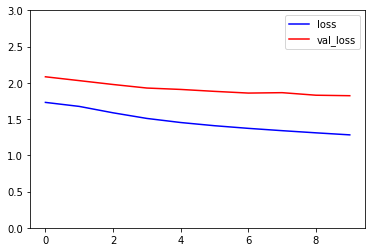

In [150]:
plt.plot(h.history['loss'], 'b-')
plt.plot(h.history['val_loss'], 'r-')
plt.ylim(0,3)
plt.legend(['loss', 'val_loss'])

In [151]:
h2 = model.fit([encoder_input_data, decoder_input_data], decoder_output_data,
              batch_size=128, epochs=120, validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/120
9000/9000 [==============================] - 191s 21ms/step - loss: 1.2554 - acc: 0.1240 - val_loss: 1.8178 - val_acc: 0.1112
Epoch 2/120
9000/9000 [==============================] - 152s 17ms/step - loss: 1.2295 - acc: 0.1268 - val_loss: 1.8049 - val_acc: 0.1108
Epoch 3/120
9000/9000 [==============================] - 159s 18ms/step - loss: 1.2050 - acc: 0.1295 - val_loss: 1.7932 - val_acc: 0.1116
Epoch 4/120
9000/9000 [==============================] - 150s 17ms/step - loss: 1.1811 - acc: 0.1321 - val_loss: 1.7891 - val_acc: 0.1135
Epoch 5/120
9000/9000 [==============================] - 154s 17ms/step - loss: 1.1580 - acc: 0.1353 - val_loss: 1.7669 - val_acc: 0.1174
Epoch 6/120
9000/9000 [==============================] - 162s 18ms/step - loss: 1.1362 - acc: 0.1376 - val_loss: 1.7494 - val_acc: 0.1208
Epoch 7/120
9000/9000 [==============================] - 156s 17ms/step - loss: 1.1156 - acc: 0.1418 - val_loss: 1.7430 - va

Epoch 118/120
9000/9000 [==============================] - 148s 16ms/step - loss: 0.4068 - acc: 0.2398 - val_loss: 1.7885 - val_acc: 0.1358
Epoch 119/120
9000/9000 [==============================] - 149s 17ms/step - loss: 0.4047 - acc: 0.2400 - val_loss: 1.8014 - val_acc: 0.1353
Epoch 120/120
9000/9000 [==============================] - 148s 16ms/step - loss: 0.4024 - acc: 0.2402 - val_loss: 1.7896 - val_acc: 0.1352


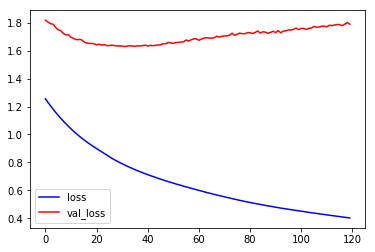

In [153]:
plt.plot(h2.history['loss'], 'b-')
plt.plot(h2.history['val_loss'], 'r-')
#plt.ylim(0,3)
plt.legend(['loss', 'val_loss'])

In [154]:
model.save('eng_fra_word_model.h5')
model.save_weights('eng_fra_word_weights.h5')
np.savez('eng_fra_word_history.npz', [h.history, h2.history])

C:\Anaconda3\envs\py36\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'lstm_5/while/Exit_4:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


### 번역하기

In [ ]:
s = 'I love you'
l = s.lower().split()
l = [word for word in l if word in eng_words][:eng_sen_max]

### 영어 입력
eng_text = np.zeros([1,eng_sen_max])
for t,word in enumerate(l):
    eng_text[0,t] = eng_w2i[word]

### 불어 입력
fra_text = np.zeros([1,fra_sen_max])
fra_text[0,0] = fra_w2i['START_']
result = []

for i in range(fra_sen_max):
    pred_y = model.predict([eng_text,fra_text])[0,i]
    
    idx = np.argmax(pred_y)
    word = fra_i2w[idx]
    result.append(word)
    
    if word=='_END' or i==(fra_sen_max-1): break
        
    fra_text[0,i+1] = idx
    
display(s,l,' '.join(result))